In [1]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as  nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
import time
from tqdm.autonotebook import tqdm, trange
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

companies = ['GAZP', 'SBER', 'LKOH', 'GMKN', 'MGNT',
       'TATN', 'NVTK', 'SNGS', 'PLZL', 'SNGSP',
       'PIKK', 'ROSN', 'SBERP', 'CHMF', 'NLMK',
       'IRAO', 'YNDX', 'ALRS', 'RUAL', 'MTSS',
       'MAGN', 'PHOR', 'RTKM', 'VTBR', 'TATNP',
       'TCSG', 'AGRO', 'OZON', 'AFLT', 'AFKS',
       'FEES', 'TRNFP', 'CBOM', 'VKCO', 'ENPG',
       'SGZH', 'FIVE', 'POLY', 'MOEX', 'GLTR',
       'HYDR', 'FIXP']

/tmp/ipykernel_39621/3897907851.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
path = '~/Рабочий стол/ДИПЛОМ НОУТБУКИ/DL forcasitng diplom/Данные Мосбиржа/Total_MOEX_hourly_with_time_df'
total_df = pd.read_csv(path)


In [3]:
data = total_df[total_df.secid == 'SBER'].drop('secid', 1)
data.head()

/tmp/ipykernel_39621/3423044560.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = total_df[total_df.secid == 'SBER'].drop('secid', 1)


,close,open,pr_change,spread_bbo,spread_lv10,spread_1mio,levels_b,levels_s,vol_b_x,vol_s_x,...,cancel_orders_b,cancel_orders_s,cancel_val_b,cancel_val_s,cancel_vol_b,cancel_vol_s,cancel_vwap_b,cancel_vwap_s,cancel_vol,cancel_orders
7969,255.97,256.15,-0.070271,1.883333,10.466667,3.691667,708.333333,405.083333,1751635.0,1894149.0,...,18271.0,17698.0,7.620925e+09,1.062276e+10,2973111.0,4054530.0,256.775000,3139.88,7027641.0,35969.0
7970,255.78,256.66,-0.342866,2.066667,10.616667,2.991667,785.416667,450.750000,2989757.0,2264926.0,...,20908.0,19313.0,9.733104e+09,1.109739e+10,3793763.0,4205430.0,256.835833,3188.13,7999193.0,40221.0
7971,257.00,257.18,-0.069990,1.375000,9.625000,2.058333,854.916667,433.500000,3811897.0,2364649.0,...,14613.0,15488.0,7.037259e+09,8.707101e+09,2735576.0,3274311.0,257.050833,3222.70,6009887.0,30101.0
7972,257.20,256.30,0.351151,1.508333,9.675000,2.216667,818.500000,526.500000,3714838.0,3203965.0,...,11519.0,16805.0,4.961394e+09,1.088500e+10,1932144.0,4215311.0,256.678333,3091.89,6147455.0,28324.0
7973,256.45,254.98,0.576516,1.283333,9.566667,1.916667,755.166667,605.916667,2982633.0,3503906.0,...,11427.0,13980.0,4.986773e+09,9.294471e+09,1944694.0,3626646.0,256.111667,3074.89,5571340.0,25407.0


In [4]:
train_data = data[ : round(data.shape[0]*0.80) ].to_numpy()

val_data = data[ round(data.shape[0]*0.80) : ].to_numpy()

In [5]:
for i in range(data.shape[1]):
    if i == 0:
        train_series = train_data[:,i].reshape(-1, 1)
        val_series = val_data[:,i].reshape(-1, 1)
    
        scaler_star = StandardScaler()
        train_series = scaler_star.fit_transform(train_series)
        val_series = scaler_star.transform(val_series)
    
        train_data[:, i] = train_series.flatten()
        val_data[:, i] = val_series.flatten()
    
    elif i != 0:
        train_series = train_data[:,i].reshape(-1, 1)
        val_series = val_data[:,i].reshape(-1, 1)
        
        scaler = StandardScaler()
        train_series = scaler.fit_transform(train_series)
        val_series = scaler.transform(val_series)
        
        train_data[:, i] = train_series.flatten()
        val_data[:, i] = val_series.flatten()

In [6]:
train_data1 = train_data[ : round(data.shape[0]*0.53) ]
train_data2 = train_data[ round(data.shape[0]*0.60) : round(data.shape[0]*0.80) ]

In [7]:
def to_sequences(seq_size, obs, dec_seq_size):
    '''
    Цена должна быть в 0 столбце!!!
    '''
    enc_in = []
    dec_in = []
    y = []
    
    for i in range(len(obs) - seq_size):
        enc_part = obs[i:(i + seq_size),:]
        dec_part = obs[i+seq_size-(dec_seq_size) : i+seq_size, : ]
        y_part = obs[i + seq_size,0]
        
        enc_in.append(enc_part)
        dec_in.append(dec_part)
        y.append(y_part)
        
    enc_in = torch.Tensor(np.array(enc_in))
    dec_in = torch.Tensor(np.array(dec_in))
    y = torch.Tensor(np.array(y))
    return enc_in, dec_in, y

In [79]:
SEQUENCE_SIZE = 32
dec_seq_size = 1

x_enc_train1, x_dec_train1, y_train1 = to_sequences(SEQUENCE_SIZE, train_data1, dec_seq_size)
x_enc_train2, x_dec_train2, y_train2 = to_sequences(SEQUENCE_SIZE, train_data2, dec_seq_size)
x_enc_val, x_dec_val, y_val = to_sequences(SEQUENCE_SIZE, val_data, dec_seq_size)


x_enc_train= torch.Tensor( np.concatenate([x_enc_train1, x_enc_train2]) )
x_dec_train= torch.Tensor( np.concatenate([x_dec_train1, x_dec_train2]) )
y_train = torch.Tensor( np.concatenate([y_train1, y_train2]) )



train_dataset = TensorDataset(x_enc_train, x_dec_train, y_train)
val_dataset  = TensorDataset(x_enc_val, x_dec_val, y_val)                           

train_loader = DataLoader(train_dataset, batch_size=150, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=150, shuffle=False)

for x_enc_train, x_dec_train, y_ in train_loader:
    print(x_enc_train.shape)
    print(x_dec_train.shape)
    print(y_.shape)
    break

torch.Size([150, 32, 57])
torch.Size([150, 1, 57])
torch.Size([150])


In [12]:
def winrate(y_true, y_pred):
    '''
    Входной формат: BatchSize*horizon(1)
    Выводит усреднённое число угаданных направлений по всему горизонту прогнозирования
    и всем батчам.
    Если горизонт = 1, то просто усредняет по батчам 
    '''
    
    diff_pred_vec = np.sign(np.diff(y_pred))
    diff_true_vec = np.sign(np.diff(y_true))
    res = np.where( diff_true_vec == diff_pred_vec , 1, 0).sum() / diff_true_vec.size
    return res


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model) #zero matriz of shape (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) #arange vector of shape (max_len,1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    '''
    input_dim: Token dim(=1 так используем только информацию о цене закрытия)
    d_model: (EBMEDDING SIZE)
    nhead: Кол-во Single attention heads в Multihead слое
    num_layers: Количество Encoder блоков в слое 
    dropout: The dropout probability.
    '''
    def __init__(self, input_dim=57, d_model=512, nhead=8, num_layers=4, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.ebedder1 = nn.Linear(input_dim, d_model)
        self.ebedder2 = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        decoder_layers = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layers, num_layers)
        self.head = nn.Linear(d_model, 1)
    
    def forward(self, x):
        enc = self.ebedder1(x[0])
        enc = self.pos_encoder(enc)
        enc = self.transformer_encoder(enc)
        dec = self.ebedder2( x[1] )
        out = self.transformer_decoder(dec, enc)[:,-1]
        out = self.head(out)
        return out

In [10]:
# def weights_adoptation(path):
#     state_dict = torch.load(path)
#     new_state_dict = {}
#     for key in state_dict:
#         new_key = key.replace('module.','')
#         new_state_dict[new_key] = state_dict[key]
#     return new_state_dict

# path = 'WEIGHTS/(512,8,4,0.1)TRANS(ENC+DEC)(M F=TI)1D|||W=0.4718, VL=1.8801'

# new_weights = weights_adoptation(path)

# model = TransformerModel().to(device)
# model.load_state_dict(new_weights)

In [41]:
model = TransformerModel( input_dim=57, d_model=512, nhead=8, num_layers=1, dropout=0.0).to(device)

In [47]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 50
early_stop_count = 0
min_val_loss = float('inf')

train_loss_per_epoch = []
val_loss_per_epoch = []
train_winrate = []
val_winrate = []



pbar = trange(epochs, desc="Epoch:")
since = time.time()

for epoch in pbar:
    model.train()
    train_losses = 0
    train_win = 0
    for batch in tqdm(train_loader, leave=False, desc="Train iter:"):
        x_enc, x_dec, y_batch = batch
        x_enc, x_dec, y_batch = x_enc.to(device), x_dec.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model( (x_enc, x_dec) )
        loss = criterion(outputs.view(-1,), y_batch)
        loss.backward()
        train_losses += loss.item()
        optimizer.step()
        train_loss = train_losses/len(train_loader)
        train_win += winrate(y_batch.cpu().detach().reshape(-1,), outputs.cpu().detach().reshape(-1,))
    train_loss_per_epoch.append(train_loss)    
    train_winrate.append(train_win / len(train_loader))
    
    # Validation
    model.eval()
    val_losses = 0
    val_win = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, leave=False, desc="Val iter:"):
            x_enc, x_dec, y_batch = batch
            x_enc, x_dec, y_batch = x_enc.to(device), x_dec.to(device), y_batch.to(device)
            outputs = model( (x_enc, x_dec) )
            loss = criterion(outputs.view(-1,), y_batch)
            val_losses += loss.item()
            val_win += winrate(y_batch.cpu().detach().reshape(-1,), outputs.cpu().detach().reshape(-1,))
    val_loss = val_losses/len(val_loader)
    val_loss_per_epoch.append(val_loss)
    val_winrate.append(val_win / len(val_loader))
    
    scheduler.step(val_loss)
    #if val_loss < 0.00012:
        #torch.save(model.state_dict(), f'МОДЕЛИ/Веса для CUSTOM_TRANS val_loss = {val_loss}' )
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 25:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}","/",f"{epochs},Train Loss: {train_loss:.8f} Validation Loss: {val_loss:.8f}")
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    

Epoch::   0%|          | 0/50 [00:00<?, ?it/s]

Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1 / 50,Train Loss: 0.07594770 Validation Loss: 0.00484592


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2 / 50,Train Loss: 0.00519291 Validation Loss: 0.00372811


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3 / 50,Train Loss: 0.00315860 Validation Loss: 0.00347881


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4 / 50,Train Loss: 0.00263522 Validation Loss: 0.00619830


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5 / 50,Train Loss: 0.00251312 Validation Loss: 0.00720038


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6 / 50,Train Loss: 0.00256142 Validation Loss: 0.00335187


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7 / 50,Train Loss: 0.00292491 Validation Loss: 0.00359229


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8 / 50,Train Loss: 0.00211430 Validation Loss: 0.00615188


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9 / 50,Train Loss: 0.00220315 Validation Loss: 0.00687943


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10 / 50,Train Loss: 0.00234004 Validation Loss: 0.00311119


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11 / 50,Train Loss: 0.00201834 Validation Loss: 0.00282004


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12 / 50,Train Loss: 0.00200091 Validation Loss: 0.00220750


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13 / 50,Train Loss: 0.00192666 Validation Loss: 0.00721151


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 14 / 50,Train Loss: 0.00223022 Validation Loss: 0.00252263


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15 / 50,Train Loss: 0.00232161 Validation Loss: 0.00402985


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 16 / 50,Train Loss: 0.00210058 Validation Loss: 0.00214538


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 17 / 50,Train Loss: 0.00243188 Validation Loss: 0.00701715


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 18 / 50,Train Loss: 0.00209621 Validation Loss: 0.00714475


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 19 / 50,Train Loss: 0.00214789 Validation Loss: 0.00145833


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 20 / 50,Train Loss: 0.00208140 Validation Loss: 0.00562092


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 21 / 50,Train Loss: 0.00292428 Validation Loss: 0.00203402


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 22 / 50,Train Loss: 0.00180498 Validation Loss: 0.00228666


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00023: reducing learning rate of group 0 to 1.5000e-04.
Epoch 23 / 50,Train Loss: 0.00161654 Validation Loss: 0.00183203


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 24 / 50,Train Loss: 0.00146736 Validation Loss: 0.00209427


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 25 / 50,Train Loss: 0.00133480 Validation Loss: 0.00134953


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 26 / 50,Train Loss: 0.00124580 Validation Loss: 0.00185476


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 27 / 50,Train Loss: 0.00132661 Validation Loss: 0.00386212


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 28 / 50,Train Loss: 0.00122426 Validation Loss: 0.00396180


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00029: reducing learning rate of group 0 to 7.5000e-05.
Epoch 29 / 50,Train Loss: 0.00125208 Validation Loss: 0.00450719


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 30 / 50,Train Loss: 0.00120818 Validation Loss: 0.00297178


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 31 / 50,Train Loss: 0.00114404 Validation Loss: 0.00286424


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 32 / 50,Train Loss: 0.00108536 Validation Loss: 0.00232056


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00033: reducing learning rate of group 0 to 3.7500e-05.
Epoch 33 / 50,Train Loss: 0.00104267 Validation Loss: 0.00180800


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 34 / 50,Train Loss: 0.00103748 Validation Loss: 0.00173979


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 35 / 50,Train Loss: 0.00103869 Validation Loss: 0.00261511


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 36 / 50,Train Loss: 0.00096636 Validation Loss: 0.00191133


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00037: reducing learning rate of group 0 to 1.8750e-05.
Epoch 37 / 50,Train Loss: 0.00094975 Validation Loss: 0.00204578


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 38 / 50,Train Loss: 0.00097564 Validation Loss: 0.00199496


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 39 / 50,Train Loss: 0.00093490 Validation Loss: 0.00212696


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 40 / 50,Train Loss: 0.00095722 Validation Loss: 0.00287766


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00041: reducing learning rate of group 0 to 9.3750e-06.
Epoch 41 / 50,Train Loss: 0.00095908 Validation Loss: 0.00221659


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 42 / 50,Train Loss: 0.00091909 Validation Loss: 0.00240831


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 43 / 50,Train Loss: 0.00092112 Validation Loss: 0.00228435


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 44 / 50,Train Loss: 0.00096652 Validation Loss: 0.00215336


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00045: reducing learning rate of group 0 to 4.6875e-06.
Epoch 45 / 50,Train Loss: 0.00091697 Validation Loss: 0.00231010


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 46 / 50,Train Loss: 0.00089907 Validation Loss: 0.00220621


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 47 / 50,Train Loss: 0.00087818 Validation Loss: 0.00232816


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 48 / 50,Train Loss: 0.00091784 Validation Loss: 0.00216185


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00049: reducing learning rate of group 0 to 2.3437e-06.
Epoch 49 / 50,Train Loss: 0.00090997 Validation Loss: 0.00228731


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Early stopping!
Training complete in 1m 1s


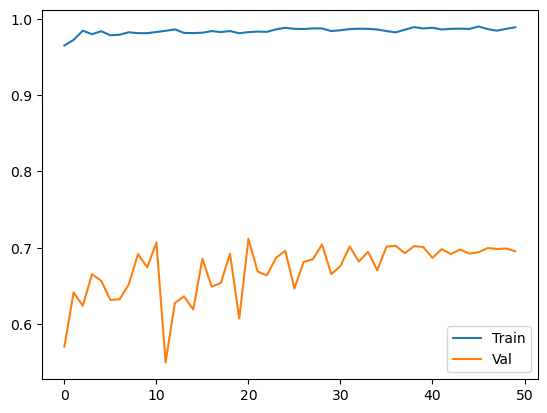

In [48]:
plt.plot(train_winrate)
plt.plot(val_winrate)
plt.legend(['Train','Val'])

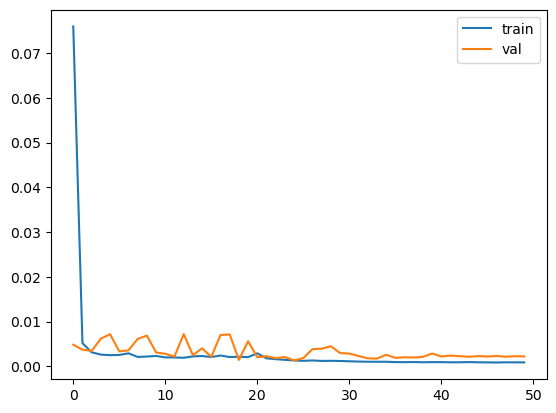

In [49]:
plt.plot(train_loss_per_epoch)
plt.plot(val_loss_per_epoch)
plt.legend(['train','val'])

In [55]:
model.eval()
predictions1 = []
with torch.no_grad():
    for batch in val_loader:
        x_enc, x_dec, y_batch = batch
        x_enc, x_dec, y_batch = x_enc.to(device), x_dec.to(device), y_batch.to(device)
        outputs = model( (x_enc, x_dec) )
        predictions1.extend(outputs.squeeze().tolist())
predictions1 = np.array(predictions1)        

In [56]:
winrate(y_val.numpy(), predictions1)

0.6984536082474226

In [57]:
predictions1 = scaler_star.inverse_transform(predictions1.reshape(-1,1))

In [59]:
y_val = scaler_star.inverse_transform(y_val.reshape(-1,1))

In [60]:
criterion(torch.Tensor(y_val),torch.Tensor(predictions1)).item()

12.524499893188477

In [73]:
train_loader = DataLoader(train_dataset, batch_size=150, shuffle=False)
model.eval()
predictions2 = []
with torch.no_grad():
    for batch in train_loader:
        x_enc, x_dec, y_batch = batch
        x_enc, x_dec, y_batch = x_enc.to(device), x_dec.to(device), y_batch.to(device)
        outputs = model( (x_enc, x_dec) )
        predictions2.extend(outputs.squeeze().tolist())
predictions2 = np.array(predictions2)

In [74]:
winrate(y_train.reshape(-1,), predictions2.reshape(-1,))

0.7667832167832168

In [75]:
y_train = scaler_star.inverse_transform(y_train.reshape(-1,1))

In [76]:
predictions2 = scaler_star.inverse_transform(predictions2.reshape(-1,1))

In [77]:
criterion(torch.Tensor(y_train), torch.Tensor(predictions2))

tensor(11.2814)

In [81]:
torch.save(model.state_dict(), f'ЧВЕСА/[512,8,1,0.0]TRANS(ENC+DEC) (M F=TI) 1D|W=0.6984, TL=11.2814 VL=12.5244' )